Here goes the code to generate the integrated object with all cell types and to compute the DR space and the FeaturePlot gene expression plots.

To execute non active code cells, turn them from markdown into code mode.

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.1-CAPI-1.17.1
and GEOS at installation 3.10.3-CAPI-1.16.1differ”
Attaching SeuratObject

Attaching sp



# Data ingestion and preparation


We will use (19?) datasets containing all cell types from the experiment.

These individual datasets have been previously loaded into Seurat objects and QC and scaling/normalisation have been applied as shown in the **Exploration** notebook.

To run this section you will need to access the datasets hosted in *DATA REPO* and uncomment the code chunks below.


In [2]:
#Define input directories

    data_dir <- "../ZenodoRepo/"

#Load data from Run 1

    dlist_OrgMonocultures <- readRDS(paste0(data_dir,"jan21_monocultures.rds"))
    dlist_OrgCocultWT <- readRDS(paste0(data_dir,"jan21_crctme_WT.rds"))
    dlist_OrgCocultA <- readRDS(paste0(data_dir,"jan21_crctme_A.rds"))
    dlist_OrgCocultAK <- readRDS(paste0(data_dir,"jan21_crctme_AK.rds"))
    dlist_OrgCocultAKP <- readRDS(paste0(data_dir,"jan21_crctme_AKP.rds"))
    dlist_MacFib <- readRDS(paste0(data_dir,"jan21_tmecontrols.rds"))

#Load data from the second run

    dlist_Run2 = readRDS(paste0(data_dir, "aug21_WT.rds"))

    for (i in 1:length(dlist_Run2)) {
        print(dlist_Run2[[i]]@project.name)
        names(dlist_Run2)[i] <- dlist_Run2[[i]]@project.name
    }
    d_20_WTWENR = dlist_Run2["WTorg_WENR"]
    rm(dlist_Run2)
    d_20_WTWENR


#Concatenate all datasets into single list

    dlist_INT <- c(d_20_WTWENR, dlist_OrgMonocultures,
        dlist_OrgCocultWT, dlist_OrgCocultA,
        dlist_OrgCocultAK, dlist_OrgCocultAKP,
        dlist_MacFib)

    for (i in 1:length(dlist_INT)) {
        # print(dlist_INT[[i]]@project.name)
        names(dlist_INT)[i] <- dlist_INT[[i]]@project.name
    }
    rm(d_20_WTWENR, dlist_OrgMonocultures, dlist_OrgCocultWT,
        dlist_OrgCocultA, dlist_OrgCocultAK, dlist_OrgCocultAKP,
        dlist_MacFib)

Need to tune plots so that scatter does not show identity and so that legend on the right does not show the colour=project.name

#Plot cell metrics and perform QC to all datasets

    p_plot <- FALSE #Set to TRUE to plot the cell metrics

    if (p_plot) {
        for (i in 1:length(dlist_INT)) {
            p1 <- VlnPlot(dlist_INT[[i]], features = c("nFeature_RNA"), 
                        ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
                    geom_hline(yintercept =1200, col="blue") &
                    geom_hline(yintercept = 7200, col="red") &
                    guides(fill="none")
            p2 <- VlnPlot(dlist_INT[[i]], features = c("nCount_RNA"), 
                        ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
                    geom_hline(yintercept =2400, col="blue") &
                    guides(fill="none")
            p3 <- VlnPlot(dlist_INT[[i]], features = c("mito_content"), 
                        ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
                    geom_hline(yintercept =3, col="red") &
                    guides(fill="none")
            p4 <- FeatureScatter(dlist_INT[[i]], 
                        feature1 = "nCount_RNA", feature2 = "nFeature_RNA",
                        group.by = "Phase", 
                        shuffle = TRUE, plot.cor = FALSE)

            print(p1 + p2 + p3 + p4 + 
            plot_layout(
                ncol = 2, guides = "collect") + 
            plot_annotation(
                title = names(dlist_INT)[i], 
                tag_levels = "A")
            )
        }
    }


    for (i in 1:length(dlist_INT)) {
        dlist_INT[[i]] <- subset(dlist_INT[[i]],
            subset = nFeature_RNA>1200 & nFeature_RNA<7200 & nCount_RNA>2400)
    }


# Integration

The datasets are integrated using Seurat's workflow for RPCA integration of datasets normalised via SCTransform.

As this computation requires over 50GB of memory, we have hosted the resulting integrated object in *DATA REPO*.
Alternatively, a downsampled version of the integrated object (with just the *RNA* assay) is stored locally in this repository and can be used to explore gene expression and metadata values on the integrated DR space.

Uncomment below cell if the input datasets have been loaded and you wish to perform the integration yourself

#Perform Integration

    for (i in 1:length(dlist_INT)) {
        #Ensure variable features are 10000 for each dataset
        print(paste0(
            dlist_INT[[i]]@project.name,
            ": ",
            length(VariableFeatures(dlist_INT[[i]]))
        ))
        # dlist_INT[[i]] <- FindVariableFeatures(dlist_INT[[i]],
        #     selection.method = "vst",
        #     nfeatures = 10000,
        #     assay = "RNA")
    }

    feats_INT = SelectIntegrationFeatures(
        object.list = dlist_INT,
        nfeatures = 2000)

    dlist_INT <- PrepSCTIntegration(
        object.list = dlist_INT,
        anchor.features = feats_INT)

    dlist_INT <- lapply(X = dlist_INT,
        FUN = RunPCA,
        features = feats_INT,
        assay = "SCT", reduction.name = "pca")

    anchor_INT <- FindIntegrationAnchors(
        dlist_INT,
        normalization.method = "SCT",
        anchor.features = feats_INT,
        reduction = "rpca", k.anchor = 12
    )
    rm(dlist_INT)

    INTepifibmac <- IntegrateData(
        anchorset = anchor_INT,
        normalization.method = "SCT"
    )

# Dimensionality Reduction

Uncomment the cell below if you want to load the already integrated object from *DATA REPO*.

#Load the already saved object:

    INTepifibmac <- readRDS("../On Request/INTepifibmac.rds)
    INTepifibmac

In [3]:
#Load a downsampled version

    downsampled_INTepifibmac <- readRDS("data/downsampled_INTepifibmac.rds")

#DR (PCA and PHATE)

    INTepifibmac <- RunPCA(INTepifibmac, assay = "integrated",
        reduction.name = "PCA")

    phate_dr <- phateR::phate(
        INTepifibmac@reductions$PCA@cell.embeddings,
        knn = 50,
        n.jobs = -2,
        seed = 12
    )
    INTepifibmac[["PHATE"]] <- CreateDimReducObject(embeddings = phate_dr$embedding,
        key="PHATE", assay = "integrated")


#Save local downsampled object after DR

    SetIdent(INTepifibmac, value = "orig.ident")
    downsampled_INTepifibmac <- subset(INTepifibmac, downsample = 50)
    #Keep only the RNA assay
    downsampled_INTepifibmac@assays$SCT <- NULL
    downsampled_INTepifibmac@assays$integrated <- NULL
    saveRDS(downsampled_INTepifibmac, "downsampled_INTepifibmac.rds")

# Gene expression plots

For this we use by default the local downsampled version of the integrated object, with DR spaces already computed.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



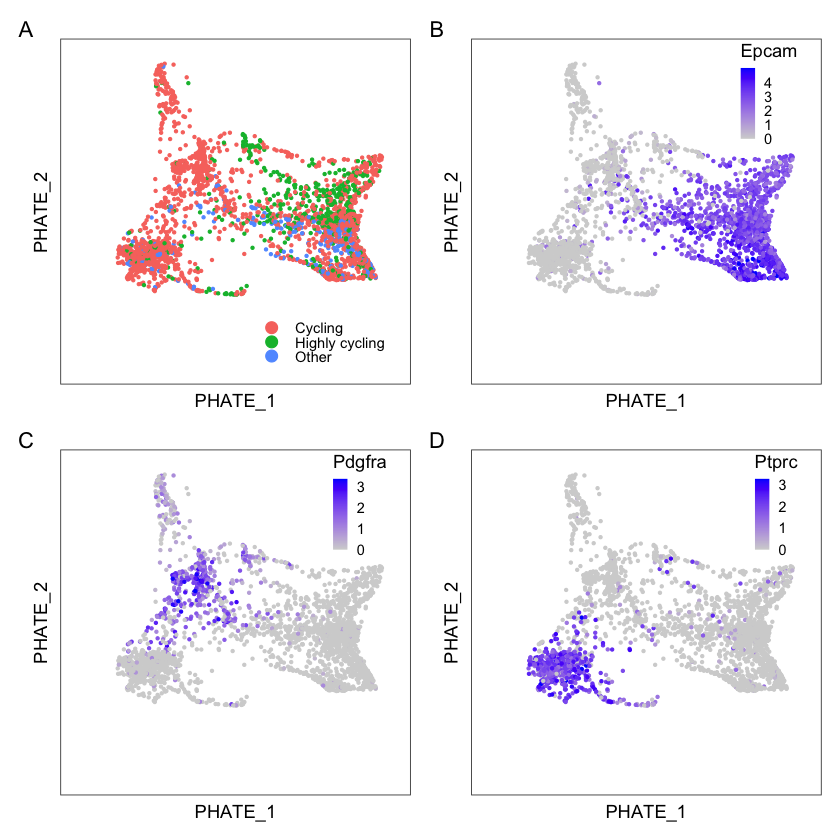

In [4]:
#Replace downsampled_INTepifibmac for INTepifibmac if using the whole object from the DATA REPO

downsampled_INTepifibmac@active.assay <- "RNA"

p0 <- DimPlot(downsampled_INTepifibmac, reduction = "PHATE",
        group.by = "Phase", shuffle = TRUE) &
    scale_x_continuous(limits = c(-0.04,0.04),
        expand = c(0, 0)) &
    scale_y_continuous(limits = c(-0.03,0.03),
        expand = c(0, 0)) &
    egg::theme_article() &
    theme(legend.position = c(.96, .24),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank()
        )  &
    labs(title = NULL)
p1 <- FeaturePlot(downsampled_INTepifibmac, 
        features = c("Epcam"), ncol = 1,
        order = FALSE, raster = NULL,
        reduction = "PHATE",
        min.cutoff = NA, max.cutoff = "q99") &
    scale_x_continuous(limits = c(-0.04,0.04),
        expand = c(0, 0)) &
    scale_y_continuous(limits = c(-0.03,0.03),
        expand = c(0, 0)) &
    egg::theme_article() &
    guides(color=guide_colorbar(ticks = FALSE, barwidth = 0.6)) &
    theme(legend.position = c(.96, 1.02),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank()
        ) &
    labs(title = NULL, colour="Epcam")
p2 <- FeaturePlot(downsampled_INTepifibmac, 
        features = c("Pdgfra"), ncol = 1,
        order = FALSE, raster = NULL,
        reduction = "PHATE",
        min.cutoff = NA, max.cutoff = "q99") &
    scale_x_continuous(limits = c(-0.04,0.04),
        expand = c(0, 0)) &
    scale_y_continuous(limits = c(-0.03,0.03),
        expand = c(0, 0)) &
    egg::theme_article() &
    guides(color=guide_colorbar(ticks = FALSE, barwidth = 0.6)) &
    theme(legend.position = c(.96, 1.02),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank()
        ) &
    labs(title = NULL, colour="Pdgfra")
p3 <- FeaturePlot(downsampled_INTepifibmac, 
        features = c("Ptprc"), ncol = 1,
        order = FALSE, raster = NULL,
        reduction = "PHATE",
        min.cutoff = NA, max.cutoff = "q99") &
    scale_x_continuous(limits = c(-0.04,0.04),
        expand = c(0, 0)) &
    scale_y_continuous(limits = c(-0.03,0.03),
        expand = c(0, 0)) &
    egg::theme_article() &
    guides(color=guide_colorbar(ticks = FALSE, barwidth = 0.6)) &
    theme(legend.position = c(.96, 1.02),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        axis.text = element_blank(),
        axis.ticks=element_blank()
        ) &
    labs(title = NULL, colour="Ptprc")

p0 + p1 + p2 + p3 + 
        plot_layout(
            ncol = 2, guides = "auto") + 
        plot_annotation( 
            tag_levels = "A")